# Feature ideas

- `num_trials_conducted`: number of trials conducted at this site in the past
- `num_conditions_conducted`: number of different diseases conducted at this site in the past
- `num_interventions_conducted`: number of different drugs conducted at this site in the past
- `num_sponsors_conducted`: number of different sponsors conducted at this site in the past

- `num_phase1_trials_conducted`: number of trials conducted at this site in the past
- `num_phase2_trials_conducted`: number of trials conducted at this site in the past
- `num_phase3_trials_conducted`: number of trials conducted at this site in the past
- `num_phase4_trials_conducted`: number of trials conducted at this site in the past

- `avg_historical_trial_success_rate`: past trial history success rate
- `avg_historical_trial_adverse_events`: past trial adverse event amount

- `max_historical_trial_enrollment`: maximum number of past trial number of participants; ideally a trial site with capacity to do large scale trial should be more mature
- `avg_historical_trial_enrollment`: average number of past trial number of participants; ideally a trial site with capacity to do large scale trial should be more mature

- `operation_years`: number of opreration years defined as number of years from the first to last trial

- `in_us`: if the trial facility locates in US
- `in_china`: if the trial facility locates in china
- `in_germany`: if the trial facility locates in germany
- `in_france`: if the trial facility locates in germany
- `in_italy`: if the trial facility locates in germany
- `in_japan`: if the trial facility locates in germany
- `in_canada`: if the trial facility locates in germany
- `in_spain`: if the trial facility locates in germany
- `in_uk`: if the trial facility locates in germany
- `in_russia`: if the trial facility locates in germany

- `is_in_california`: if the trial facility locates in US california
- `is_in_florida`: if the trial facility locates in US florida
- `is_in_texas`: if the trial facility locates in US texas
- `is_in_ny`: if the trial facility locates in US ny
- `is_in_penn`: if the trial facility locates in US penn
- `is_in_nc`: if the trial facility locates in US north carolina

- `years_since_last_trial_facility`: how recent is the lastest trial

- `in_multi_center_trial`: has this site be part of a larger multi-center study?
- `num_multi_center_trial`: how many times have this trial be part of a larger multi-center study?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from relbench.datasets import get_dataset
from relbench.tasks import get_task

from tqdm import tqdm 
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 10)

%load_ext autoreload
%autoreload 2


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
def get_features(train_df):
    dataset = get_dataset(name='rel-trial', process=False)
    task = get_task('rel-trial', 'site-success', download=True)
    tables = dataset.get_db().table_dict

    interventions_studies = tables['interventions_studies'].df
    conditions_studies = tables['conditions_studies'].df
    sponsors_studies = tables['sponsors_studies'].df
    facilities_studies = tables['facilities_studies'].df
    studies = tables['studies'].df
    designs = tables['designs'].df
    eligibilities = tables['eligibilities'].df
    sponsors = tables['sponsors'].df
    reported_event_totals = tables["reported_event_totals"].df
    
    outcomes = tables['outcomes'].df
    facilities = tables['facilities'].df
    outcome_analyses = tables['outcome_analyses'].df
    outcome_analyses = outcome_analyses.merge(outcomes[['id', 'outcome_type']], left_on='outcome_id', right_on = 'id')

    def get_derived_features(facility_id, timestamp):
        try:
            history_ncts = facilities_studies[(facilities_studies.facility_id == facility_id) & (facilities_studies.date < timestamp)].nct_id.unique()
            num_trials_conducted = len(history_ncts)
            num_conditions_conducted = len(conditions_studies[conditions_studies.nct_id.isin(history_ncts)].condition_id.unique())
            num_interventions_conducted = len(interventions_studies[interventions_studies.nct_id.isin(history_ncts)].intervention_id.unique())
            num_sponsors_conducted = len(sponsors_studies[sponsors_studies.nct_id.isin(history_ncts)].sponsor_id.unique())
        
            studies_temp = studies[studies.nct_id.isin(history_ncts)]
            studies_temp['phase'] = studies_temp.phase.astype(str)
            num_phase1 = len(studies_temp[studies_temp.phase.str.contains('1')])
            num_phase2 = len(studies_temp[studies_temp.phase.str.contains('2')])
            num_phase3 = len(studies_temp[studies_temp.phase.str.contains('3')])
            num_phase4 = len(studies_temp[studies_temp.phase.str.contains('4')])
        
            outcome_temp = outcome_analyses[outcome_analyses.nct_id.isin(history_ncts)]
            outcome_temp = outcome_temp[(outcome_temp.p_value_modifier.isnull()) | (outcome_temp.p_value_modifier != '>')]
            outcome_temp = outcome_temp[(outcome_temp.p_value >= 0) & (outcome_temp.p_value <= 1) & (outcome_temp.outcome_type == 'Primary')]
            nct2p = outcome_temp.groupby('nct_id').p_value.min()
            if len(nct2p) == 0:
                avg_history_success_rate = 0
            else:
                avg_history_success_rate = sum(nct2p<= 0.05)/len(nct2p)
        
            event_temp = reported_event_totals[reported_event_totals.nct_id.isin(history_ncts)]
            event_temp = event_temp[(event_temp.event_type == 'serious') | (event_temp.event_type == 'deaths')]
            event_temp = event_temp[~event_temp.subjects_affected.isnull()]
            nct2event = event_temp.groupby('nct_id').subjects_affected.sum()
        
            if len(nct2event) == 0:
                avg_history_adverse_events = 0
            else:
                avg_history_adverse_events = sum(nct2event)/len(nct2event)
            
            max_historical_trial_enrollment = studies_temp.enrollment.max()
            avg_historical_trial_enrollment = studies_temp.enrollment.mean()
        
            operation_years = (studies_temp.start_date.max().year - studies_temp.start_date.min().year)
            years_since_last_trial_facility = timestamp.year - studies_temp.start_date.max().year
        
            nct2num_facility = dict(facilities_studies[(facilities_studies.nct_id.isin(history_ncts))].groupby('nct_id').facility_id.agg(len))
            if len(nct2num_facility) == 0:
                in_multi_center_trial = 0
                num_multi_center_trial = 0
            else:
                if min(nct2num_facility.values()) > 1:
                    in_multi_center_trial = 1
                else:
                    in_multi_center_trial = 0
                num_multi_center_trial = sum([1 if j > 1 else 0 for i,j in nct2num_facility.items()])
        
            return [num_trials_conducted, num_conditions_conducted, num_interventions_conducted, num_sponsors_conducted, 
                    num_phase1, num_phase2, num_phase3, num_phase4,
                    avg_history_success_rate,  avg_history_adverse_events, max_historical_trial_enrollment, avg_historical_trial_enrollment,
                    operation_years, years_since_last_trial_facility, in_multi_center_trial, num_multi_center_trial]
        except Exception as e:
            print(e)
    
    train_df['derived_features'] = train_df.parallel_apply(lambda x: get_derived_features(x.facility_id, x.timestamp), axis = 1)

    facility_to_merge_col = []
    for country in facilities.country.value_counts()[:10].keys():
        facilities['in_' + country.lower()] = facilities['country'].apply(lambda x: 1 if x == country else 0)
        facility_to_merge_col.append('in_' + country.lower())

    for state in facilities.state.value_counts()[:10].keys():
        facilities['in_' + state.lower() + '_state'] = facilities['state'].apply(lambda x: 1 if x == state else 0)
        facility_to_merge_col.append('in_' + state.lower()+ '_state')

    for city in facilities.city.value_counts()[:10].keys():
        facilities['in_' + city.lower()+ '_city'] = facilities['city'].apply(lambda x: 1 if x == city else 0)
        facility_to_merge_col.append('in_' + city.lower()+ '_city')

    train_df = train_df.merge(facilities[['facility_id'] + facility_to_merge_col], how = 'left')
    feature_list = "num_trials_conducted, num_conditions_conducted, num_interventions_conducted, num_sponsors_conducted, num_phase1, num_phase2, num_phase3, num_phase4,avg_history_success_rate,  avg_history_adverse_events, max_historical_trial_enrollment, avg_historical_trial_enrollment,operation_years, years_since_last_trial_facility, in_multi_center_trial, num_multi_center_trial".split(',')
    feature_list = [i.strip() for i in feature_list]

    expanded_df = pd.DataFrame(train_df['derived_features'].tolist(), columns=feature_list)
    train_df = train_df.drop(columns=['derived_features'])
    train_df = pd.concat([train_df, expanded_df], axis=1)

    return train_df

In [3]:
dataset = get_dataset(name='rel-trial', process=False)
task = get_task('rel-trial', 'site-success', download=True)

loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.50 seconds.


In [6]:
val_df = task.get_table("val").df
val_df = get_features(val_df)

loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.32 seconds.


In [ ]:
train_df = task.get_table("train").df
train_df = get_features(train_df)

loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.55 seconds.


In [13]:
train_df = train_df.fillna(0)
val_df = val_df.fillna(0)

In [14]:
from torch_frame import TaskType, stype
from torch_frame.gbdt import LightGBM, XGBoost
from torch_frame.data import Dataset
from torch_frame.typing import Metric
from torch_frame.utils import infer_df_stype

col_to_stype = infer_df_stype(train_df)
col_to_stype

DROP_COLS = [
    # drop identifier cols
    'facility_id',
    'timestamp',
]
for c in DROP_COLS:
    del col_to_stype[c]

train_dset = Dataset(
    train_df.drop(DROP_COLS, axis=1),
    col_to_stype=col_to_stype,
    target_col='success_rate'
).materialize()

val_tf = train_dset.convert_to_tensor_frame(val_df.drop(DROP_COLS, axis=1))
tune_metric = Metric.MAE
print(train_dset.tensor_frame.num_cols, train_dset.tensor_frame.num_rows)

gbdt = LightGBM(TaskType.REGRESSION, metric=tune_metric)
gbdt.tune(tf_train=train_dset.tensor_frame, tf_val=val_tf, num_trials=10)

#gbdt.save('site_lightgbm.json')

[I 2024-06-01 13:06:00,788] A new study created in memory with name: no-name-96d5a219-189f-4a0d-8206-f4e66cb241fb


46 151407


[I 2024-06-01 13:12:14,071] Trial 0 finished with value: 0.2411749240647467 and parameters: {'max_depth': 6, 'learning_rate': 0.009374233771440914, 'num_leaves': 717, 'subsample': 0.8127270912833771, 'colsample_bytree': 0.9113120776508753, 'lambda_l1': 0.439395543864618, 'lambda_l2': 3.7202031196046144e-07, 'min_data_in_leaf': 47}. Best is trial 0 with value: 0.2411749240647467.
[I 2024-06-01 13:12:39,904] Trial 1 finished with value: 0.23168118661991252 and parameters: {'max_depth': 4, 'learning_rate': 0.005540708429510222, 'num_leaves': 341, 'subsample': 0.48940810897905435, 'colsample_bytree': 0.9003079760327557, 'lambda_l1': 0.008534462973664461, 'lambda_l2': 0.8163863266588068, 'min_data_in_leaf': 89}. Best is trial 1 with value: 0.23168118661991252.


[2000]	valid_0's l1: 0.274162


[I 2024-06-01 13:14:24,550] Trial 2 finished with value: 0.2741594563506618 and parameters: {'max_depth': 7, 'learning_rate': 0.002417728370938764, 'num_leaves': 733, 'subsample': 0.7269963535996694, 'colsample_bytree': 0.46115234004158745, 'lambda_l1': 0.0006433350689781812, 'lambda_l2': 6.343830302723894, 'min_data_in_leaf': 62}. Best is trial 1 with value: 0.23168118661991252.
[I 2024-06-01 13:14:43,029] Trial 3 finished with value: 0.28245097364942867 and parameters: {'max_depth': 3, 'learning_rate': 0.0012307985963629909, 'num_leaves': 171, 'subsample': 0.22741278748362237, 'colsample_bytree': 0.6040196650431013, 'lambda_l1': 0.0061327495672202255, 'lambda_l2': 0.042352113299460245, 'min_data_in_leaf': 83}. Best is trial 1 with value: 0.23168118661991252.


[2000]	valid_0's l1: 0.282451


[I 2024-06-01 13:14:44,995] Trial 4 finished with value: 0.399660842003851 and parameters: {'max_depth': 7, 'learning_rate': 0.08917746460811718, 'num_leaves': 945, 'subsample': 0.44698505114677983, 'colsample_bytree': 0.05175105063185792, 'lambda_l1': 1.1034065468200428e-08, 'lambda_l2': 1.3704113777602029e-06, 'min_data_in_leaf': 61}. Best is trial 1 with value: 0.23168118661991252.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[I 2024-06-01 13:15:21,269] Trial 5 finished with value: 0.25348435814158754

[2000]	valid_0's l1: 0.236756


[I 2024-06-01 13:18:19,250] Trial 9 finished with value: 0.2891520744897451 and parameters: {'max_depth': 8, 'learning_rate': 0.06859953564453715, 'num_leaves': 59, 'subsample': 0.18946687464709416, 'colsample_bytree': 0.21393502625508737, 'lambda_l1': 1.8696388909944123e-06, 'lambda_l2': 6.229209909606132e-08, 'min_data_in_leaf': 77}. Best is trial 1 with value: 0.23168118661991252.


In [15]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

In [16]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
pred = gbdt.predict(tf_test=val_tf)
pred_ = np.rint(pred.numpy())  # round to nearest int
# Entire val set
y_ = val_tf.y.numpy()
mae = mean_absolute_error(y_, pred_)
tmae = mean_absolute_error(y_, np.zeros_like(y_))
binacc = accuracy_score((y_ > 0).astype(int), (pred_ > 0).astype(int))

print('ALL VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"MAE: {mae:.3f}")
print(f"Binary Accuracy: {binacc:.1%}")
print()

# nonzero entries
nzy = y_[y_ != 0]
nzp = pred_[y_ != 0]
mae = mean_absolute_error(nzy, nzp)
tmae = mean_absolute_error(nzy, np.zeros_like(nzy))

print('NONZERO VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"MAE: {mae:.3f}")

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[:5000])
shap_values = explainer.shap_values(val_arr, pred_[:5000])

ALL VAL
Trivial MAE: 0.475
MAE: 0.237
Binary Accuracy: 73.8%

NONZERO VAL
Trivial MAE: 0.911
MAE: 0.217


In [17]:
# TODO verify
feat_names = val_tf.col_names_dict[stype.categorical] + val_tf.col_names_dict[stype.numerical]

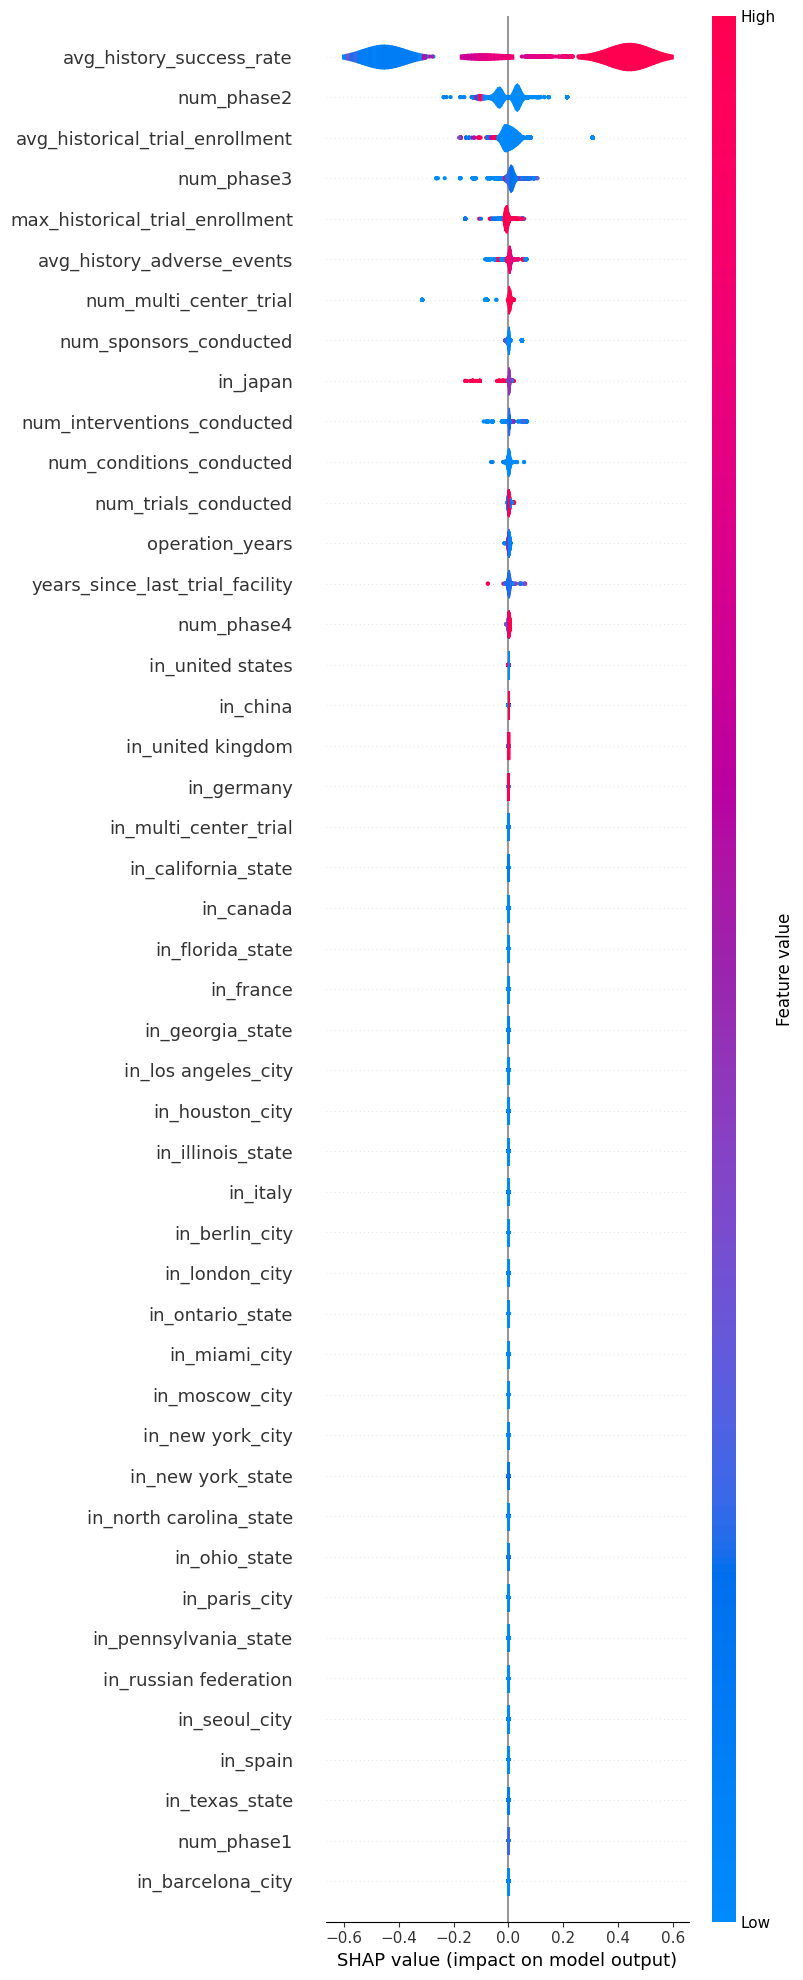

In [18]:
shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=50,
                  feature_names=feat_names)

In [19]:
test_df = task.get_table("test").df
test_df = get_features(test_df)
test_tf = train_dset.convert_to_tensor_frame(test_df.drop(DROP_COLS, axis=1))
pred = gbdt.predict(tf_test=test_tf)
task.evaluate(pred)

loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.71 seconds.


In [28]:
task.evaluate(pred_map)

{'mae': 0.4438253601943365, 'rmse': 0.6379138699464498}

In [29]:
test_df

,timestamp,facility_id,in_united states,in_germany,in_france,in_italy,in_japan,in_canada,in_spain,in_china,...,num_phase3,num_phase4,avg_history_success_rate,avg_history_adverse_events,max_historical_trial_enrollment,avg_historical_trial_enrollment,operation_years,years_since_last_trial_facility,in_multi_center_trial,num_multi_center_trial
0,2021-01-01,37099,1,0,0,0,0,0,0,0,...,3,0,0.500000,91.333333,1943.0,427.500000,8.0,7.0,1,8
1,2021-01-01,10995,1,0,0,0,0,0,0,0,...,4,0,0.000000,66.000000,1943.0,409.636364,11.0,4.0,1,11
2,2021-01-01,2817,1,0,0,0,0,0,0,0,...,14,0,0.833333,219.590909,3509.0,694.303030,15.0,3.0,1,33
3,2021-01-01,3536,1,0,0,0,0,0,0,0,...,64,0,0.370370,79.924731,17463.0,431.960938,20.0,1.0,0,240
4,2021-01-01,84951,1,0,0,0,0,0,0,0,...,5,0,0.500000,92.750000,1943.0,635.666667,8.0,7.0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22612,2021-01-01,223998,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,5484.0,5484.000000,0.0,1.0,1,1
22613,2021-01-01,224402,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,5484.0,5484.000000,0.0,1.0,1,1
22614,2021-01-01,224153,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,5484.0,5484.000000,0.0,1.0,1,1
22615,2021-01-01,224092,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,5484.0,5484.000000,0.0,1.0,1,1


In [30]:
task_name = 'rel-trial-site'
train_df.to_csv(task_name + '-train.csv', index = False)
val_df.to_csv(task_name + '-val.csv', index = False)
test_df.to_csv(task_name + '-test.csv', index = False)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
